# xapm_db_stat 데이터 분석

by pdm

In [1]:
from __future__ import division
import google.datalab.bigquery as bq
import matplotlib.pyplot as plot
import numpy as np
import pandas as pd

# BigQuery로 xapm_db 테이블 불러와서, db_id = 6 인 놈만 stat_id 로 grouping하기

In [2]:
%bq tables list --project exem-191100 --dataset ods_im5

In [10]:
%%bq query --name stat
SELECT stat_id, COUNT(stat_id) as count, Max(value) as max_value, AVG(value) as avg_value, MIN(value) as min_value
FROM `exem-191100.ods_im5.xapm_db_stat`
WHERE db_id = 6
GROUP BY stat_id
HAVING (max_value = 0 and min_value = 0)
ORDER BY stat_id

In [12]:
%%bq sample --query stat --count 1000

stat_id,count,max_value,avg_value,min_value
0,44303,0,0.0,0
15,44303,0,0.0,0
16,44303,0,0.0,0
17,44303,0,0.0,0
21,44303,0,0.0,0
36,44303,0,0.0,0
39,44303,0,0.0,0
40,44303,0,0.0,0
42,44303,0,0.0,0
46,44303,0,0.0,0


각 stat 이 모두 44,303 번 측정되었는데, 이는 os_stat에서 **db_id = 6** 인 row의 수 (44,306)과 **거의 같다.**

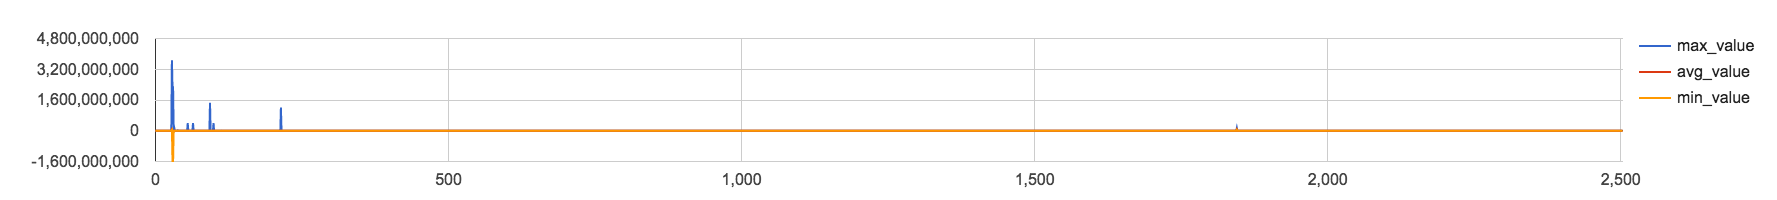

In [4]:
%chart line --data stat --fields stat_id,max_value,avg_value,min_value

chart를 x축 stat_id (x축) 에따라 plotting 하면 중간중간 확 뛰는 값들을 몇개 확인할 수 있다.

- anomaly라도 보아도 될까?

In [6]:
%%bq query --name stat_count
SELECT count(stat_id) as stat_count
FROM(
  SELECT stat_id, COUNT(stat_id) as count, Max(value) as max_value, AVG(value) as avg_value, MIN(value) as min_value
  FROM `exem-191100.ods_im5.xapm_db_stat`
  WHERE db_id = 6
  GROUP BY stat_id
  HAVING (max_value <> 0 and min_value <> 0)
)


In [7]:
%%bq sample --query stat_count

stat_count
100


**총 1374 개의 stat**이 있음을 알 수 있다. 2000여개의 stat 중 몇개가 중간중간 비어있는것 같다.

- BigQuery 창에서 직접 돌려서 확인해보니 **(0~686, 1817~2503)**로 indexing 되어 있음을 알 수 있었다

# value > avg_value x 10 , value < avg_value x 0.1 인 놈들을 anomaly라고 가정하고 찾기

In [15]:
%%bq query --name cutting
SELECT t1.stat_id, t1.value, t1.time
FROM `exem-191100.ods_im5.xapm_db_stat` as t1, 
    (SELECT stat_id, AVG(value) as avg_value
    FROM `exem-191100.ods_im5.xapm_db_stat`
    WHERE db_id = 6
    GROUP BY stat_id) as t2
WHERE t2.stat_id = t1.stat_id and ( t2.avg_value*10<t1.value or t2.avg_value*0.1>t1.value )
ORDER BY time

In [16]:
%%bq sample --query cutting

stat_id,time,value
622,2017-11-03 15:00:00,0
241,2017-11-03 15:00:00,260
81,2017-11-03 15:00:00,0
83,2017-11-03 15:00:00,0
132,2017-11-03 15:00:00,0
2,2017-11-03 15:00:00,1
317,2017-11-03 15:00:00,0
352,2017-11-03 15:00:00,35056
150,2017-11-03 15:00:00,0
313,2017-11-03 15:00:00,0


In [21]:
%%bq query --name counting
SELECT COUNT(value) as count
FROM (SELECT t1.stat_id, t1.value, t1.time
      FROM `exem-191100.ods_im5.xapm_db_stat` as t1, 
          (SELECT stat_id, AVG(value) as avg_value
          FROM `exem-191100.ods_im5.xapm_db_stat`
          WHERE db_id = 6
          GROUP BY stat_id) as t2
      WHERE t1.stat_id = t2.stat_id and (t2.avg_value*10<t1.value or t2.avg_value*0.1>t1.value) and t1.value <> 0
      ORDER BY time)

In [22]:
%%bq sample --query counting

count
5058024


총 187717458 개의 row 중에 5058024 개가 10배, 0.1배 바깥의 범위에 있었다. **약 0.02694488 = 2.69% 의 비율**이다..

- **anomaly라고 볼 수 있는가?**

# 이 작업을 db_id = 13,16 에 대해서도 반복할 수 있다.